In [1]:
import os
import random
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Set environment, path, and parameters
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '../../data'
SEED = 92
EXP_NUM = 30 # Suggest to set EXP_NUM multiple of 3

In [3]:
def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes,
                                device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [4]:
def cross_entropy_for_onehot(target, pred):
    return torch.mean(torch.sum(-target * F.log_softmax(pred, dim=-1), 1))

In [5]:
def create_simulation_model(input_size=784, output_size=10, hidden_sizes=[],
                            activation_func=nn.Sigmoid()):
    # Layer details for the neural network
    num_neuron = [input_size] + hidden_sizes + [output_size]

    # Build a feed-forward network
    layers = []
    for i in range(1, len(num_neuron)):
        layers.append(nn.Linear(num_neuron[i-1], num_neuron[i]))
        if i != len(num_neuron) - 1:
            layers.append(activation_func)
    
    model = nn.Sequential(*layers)
    return model

In [6]:
# Get dataset
dst = datasets.MNIST(DATA_DIR, download=True)
print('Total %d data' % len(dst))

Total 60000 data


In [7]:
# Get sample indices
random.seed(SEED)
sample_indices = random.choices(range(len(dst)), k=EXP_NUM)
print(sample_indices)

[25262, 33894, 33488, 35331, 48046, 58012, 40356, 48528, 34216, 28289, 50299, 59756, 34354, 37862, 3729, 51724, 38507, 38017, 9896, 34877, 36356, 9406, 24693, 44614, 46805, 42780, 40430, 57066, 47461, 4094]


In [8]:
# Define data transformation
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
# Get ground truth images and labels
images = torch.stack([transform(dst[idx][0]).float()
                      for idx in sample_indices]).to(device)
labels = torch.Tensor([dst[idx][1]
                       for idx in sample_indices]).long().to(device)

# Input X, Y
flatten_images = images.view(images.shape[0], -1)
onehot_labels = label_to_onehot(labels)
print(flatten_images.shape)
print(onehot_labels.shape)

torch.Size([30, 784])
torch.Size([30, 10])


In [10]:
# Define criterion
criterion = cross_entropy_for_onehot

In [11]:
def run_simulation(X, Y, model, criterion):
    assert X.shape[0] == Y.shape[0], 'Mismatch simulate data amount'
    
    recover_images = []
    recover_labels = []
    
    for i in range(X.shape[0]):
        # Get each data
        x, y = X[i].unsqueeze(0), Y[i].unsqueeze(0)

        # Forward pass, then backward pass
        output = model(x)
        loss = criterion(y, output)
        loss.backward()

        # Get first and last layer weight and bias gradient
        w_grad_first = model[0].weight.grad.clone()
        b_grad_first = model[0].bias.grad.clone()
        b_grad_last = model[-1].bias.grad.clone()
        
        # Recovery image and label
        try:
            assert (b_grad_first ** 2).sum() > 0, \
                'Zero gradient bias, failed to recover image!'
            for i in range(b_grad_first.shape[0]):
                if b_grad_first[i] != 0:
                    recover_image = w_grad_first[i] / b_grad_first[i]
        except AssertionError as error:
            print(error)
            print('Recover image by weight gradient!')
            recover_image = w_grad_first[i]

        recover_label = torch.argmin(b_grad_last, dim=-1).item()

        recover_images.append(recover_image)
        recover_labels.append(recover_label)

        # Set zero gradient
        model[0].weight.grad.data.zero_()
        model[0].bias.grad.data.zero_()
        model[-1].bias.grad.data.zero_()

    recover_images = torch.stack(recover_images)
    recover_labels = torch.Tensor(recover_labels)
    return recover_images, recover_labels

In [12]:
def evaluate_recovered_data(X, Y, ri, rl):
    image_success = torch.allclose(X, ri)
    label_success = torch.all(Y == rl).item()
    print('Image recovered successfully!' if image_success else 'Image failed to recovered!')
    print('Label recovered successfully!' if label_success else 'Label failed to recovered!')

In [13]:
def plot_recovered_data(X, Y, ri, rl, image_size, title, cols=6, fig_path=None):
    rows = X.shape[0] * 2 // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2.5*rows+1.5),
                             constrained_layout=True)
    fig.suptitle(title, fontsize=18)

    for i in range(rows * cols // 2):
        # Plot ground truth data and recovered data
        axes[i * 2 // cols, i * 2 % cols].imshow(X[i].numpy().reshape(image_size),
                                                 cmap='gray')
        axes[i * 2 // cols, i * 2 % cols].set_title('GT label=%d' % int(Y[i]))
        axes[i * 2 // cols, i * 2 % cols].axis('off')
        axes[i * 2 // cols, i * 2 % cols + 1].imshow(ri[i].numpy().reshape(image_size),
                                                     cmap='gray')
        axes[i * 2 // cols, i * 2 % cols + 1].set_title('Re label=%d' % int(rl[i]))
        axes[i * 2 // cols, i * 2 % cols + 1].axis('off')

    # Save figure
    if fig_path is not None:
        fig.savefig(fig_path, bbox_inches='tight')
    fig.show()

<h1> Simulate Single Layer Model </h1>

In [14]:
# Create simulation model
sim_model = create_simulation_model()
sim_model.to(device)
print(sim_model)
print('\nTotal %d layers' % len(sim_model))

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
)

Total 1 layers


In [15]:
recover_images, recover_labels = run_simulation(
    flatten_images, onehot_labels, sim_model, criterion)
evaluate_recovered_data(flatten_images, labels.cpu(),
                        recover_images, recover_labels)

Image recovered successfully!
Label recovered successfully!


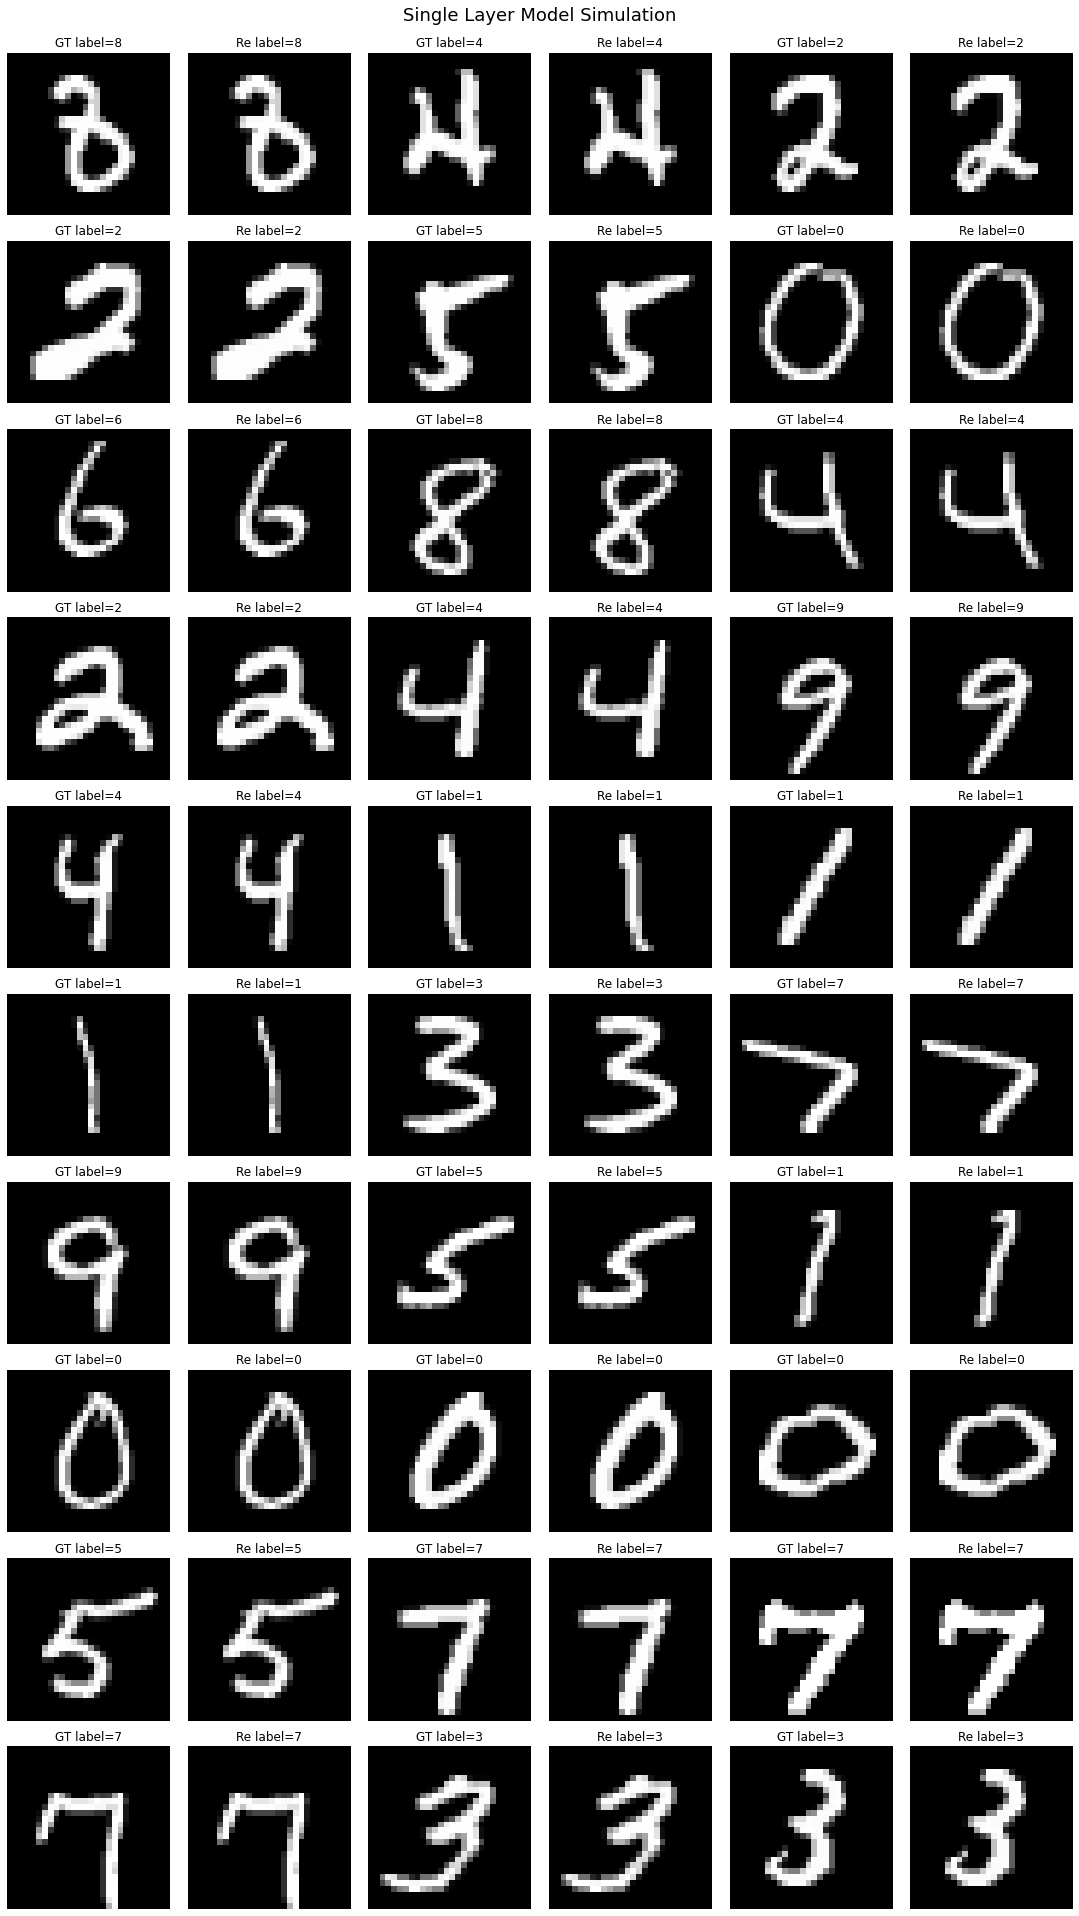

In [16]:
plot_recovered_data(flatten_images.cpu(), labels.cpu(),
                    recover_images.cpu(), recover_labels, 
                    image_size=(28, 28), title='Single Layer Model Simulation')

<h1> Simulate Multi-Layer Model with ReLU </h1>

In [17]:
# Create simulation model
sim_model = create_simulation_model(hidden_sizes=[128, 64])
sim_model.to(device)
print(sim_model)
print('\nTotal %d layers' % len(sim_model))

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

Total 5 layers


In [18]:
recover_images, recover_labels = run_simulation(
    flatten_images, onehot_labels, sim_model, criterion)
evaluate_recovered_data(flatten_images, labels.cpu(),
                        recover_images, recover_labels)

Image recovered successfully!
Label recovered successfully!


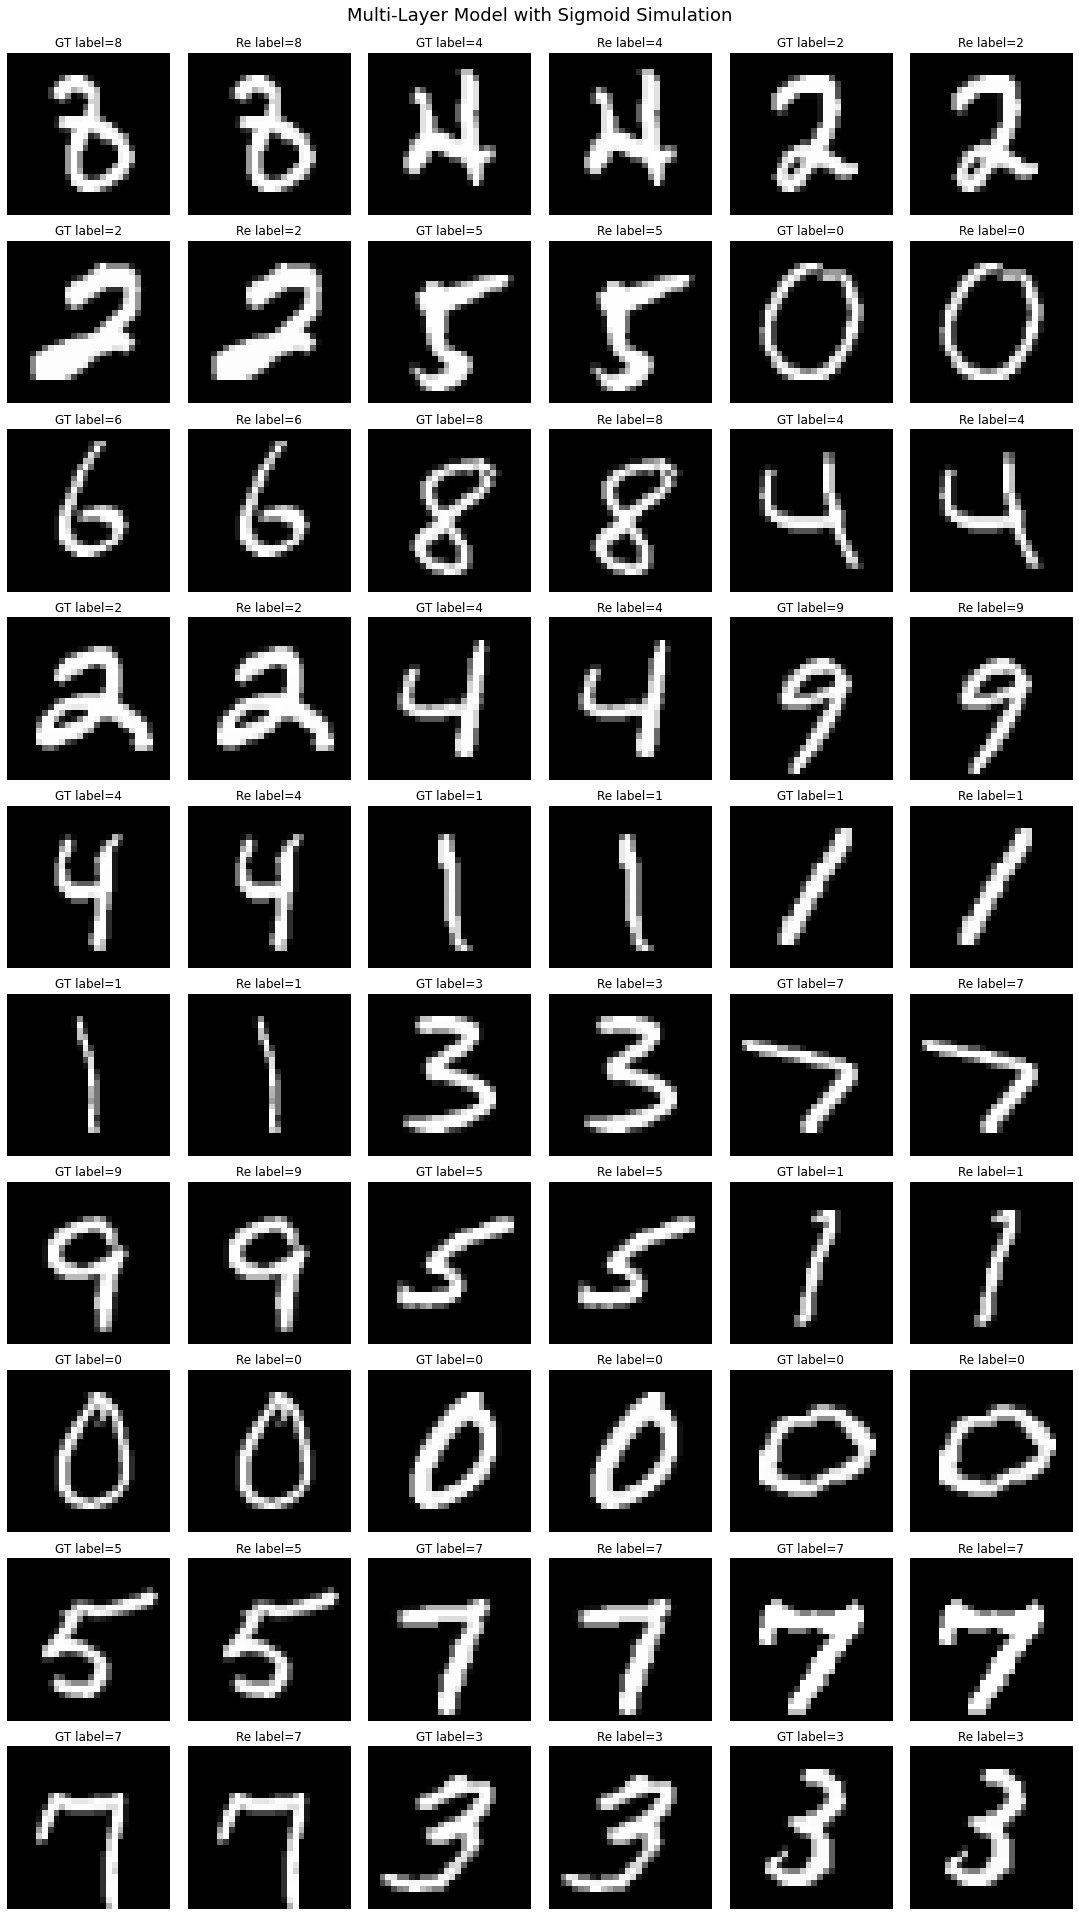

In [19]:
plot_recovered_data(flatten_images.cpu(), labels.cpu(),
                    recover_images.cpu(), recover_labels, 
                    image_size=(28, 28), title='Multi-Layer Model with Sigmoid Simulation')

<h1> Simulate Multi-Layer Model with ReLU </h1>

In [20]:
# Create simulation model
sim_model = create_simulation_model(hidden_sizes=[128, 64],
                                    activation_func=nn.ReLU())
sim_model.to(device)
print(sim_model)
print('\nTotal %d layers' % len(sim_model))

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

Total 5 layers


In [21]:
recover_images, recover_labels = run_simulation(
    flatten_images, onehot_labels, sim_model, criterion)
evaluate_recovered_data(flatten_images, labels.cpu(),
                        recover_images, recover_labels)

Image recovered successfully!
Label recovered successfully!


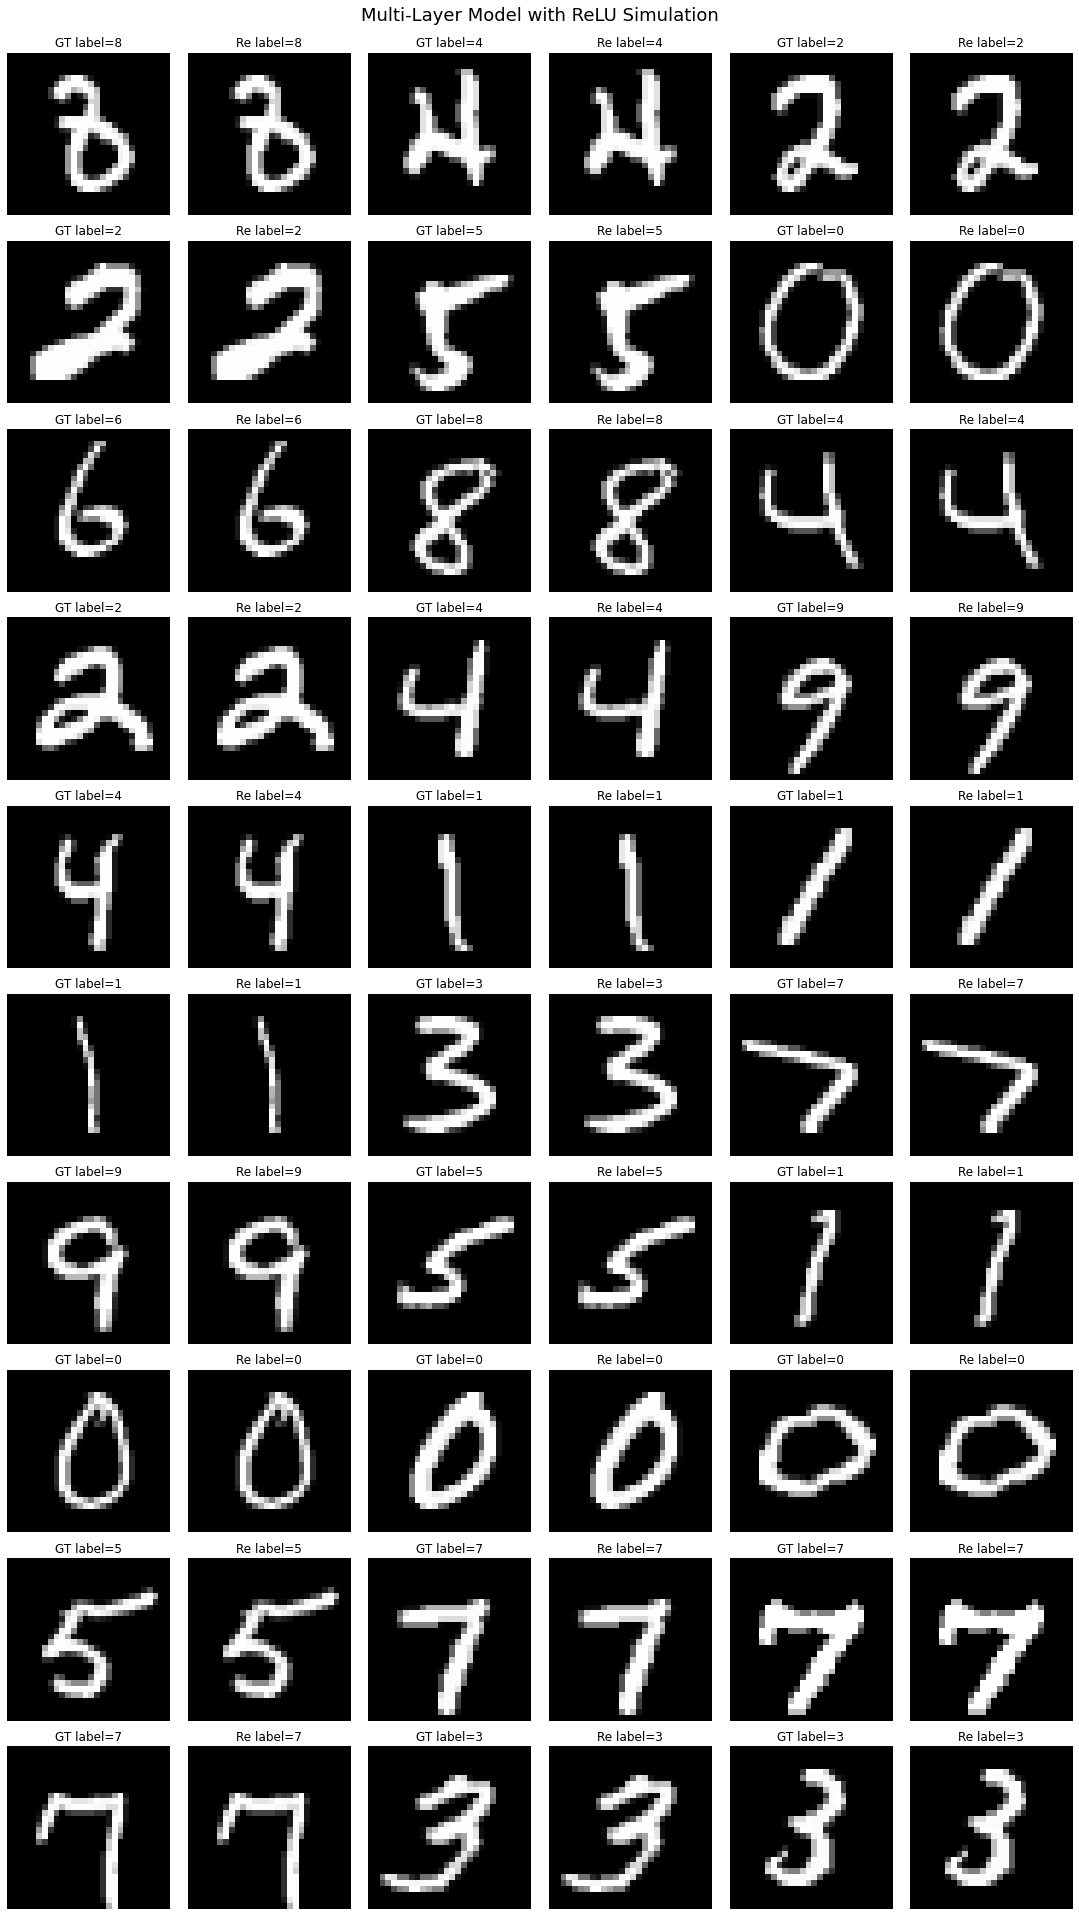

In [22]:
plot_recovered_data(flatten_images.cpu(), labels.cpu(),
                    recover_images.cpu(), recover_labels, 
                    image_size=(28, 28), title='Multi-Layer Model with ReLU Simulation')